# Reproducing Bevan et Atapour-Abarghouei (2022).

This notebook will assess the effect of the use of the arctan vs the arctan2. It will reproduce the ITA calculation of Bevan et Atapour-Abarghouei to verify the correct adaption of their code and then it will replace the arctan with the arctan2.
The code was adapted from https://github.com/pbevan1/Detecting-Melanoma-Fairly/blob/main/preprocessing.py


In [4]:
# create the usual variables: datapath, dataframes to get the images etc
from utils import prepare_df
TRAINING_PATH = "./data/ISIC2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/"
df_labels = prepare_df(TRAINING_PATH)

In [62]:
## From Bevan et Atapour-Abarghouei
import pandas as pd
import cv2
from PIL import Image
import math
from skimage import io, color
from matplotlib import pyplot as plt
import numpy as np

def bin_ITA(ita_max):
    ita_bnd_kin=-1
    if ita_max > 55:
        ita_bnd_kin = 1
    if 41 < ita_max <= 55:
        ita_bnd_kin = 2
    if 28 < ita_max <= 41:
        ita_bnd_kin = 3
    if 19 < ita_max <= 28:
        ita_bnd_kin = 4
    if 10 < ita_max <= 19:
        ita_bnd_kin = 5
    if ita_max <= 10:
        ita_bnd_kin = 6
    return ita_bnd_kin

# Hair removal for ITA calculation
def hair_remove(image):
    # Convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Kernel for morphologyEx
    kernel = cv2.getStructuringElement(1, (17, 17))
    # Apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # Apply thresholding to blackhat
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # Inpaint with original image and threshold image
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
    return final_image

# Calculates Fitzpatrick skin type of an image using Kinyanjui et al.'s thresholds
def get_sample_ita_kin(path,size=256):
    ita_type = -1
    ita2_type = -1
    try:
        im = cv2.imread(path) # cv2 image is numpy array
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        # if image wider than long centre crop by smallest side
        if im.shape[1] < im.shape[0]:
            dim1 = int(im.shape[1])
            dim0 = int(im.shape[0])
            chi = int((dim0 - dim1) / 2)
            im = im[chi:chi + dim1, 0:dim1]
        else:
            # if image longer than wide centre crop by smallest side
            dim1 = int(im.shape[0])
            dim0 = int(im.shape[1])
            chi = int((dim0 - dim1) / 2)
            im = im[0:dim1, chi:chi + dim1]
        im = Image.fromarray(im, 'RGB') # converts to PIL image for resizing
        # resizing
        im = im.resize((size, size), Image.Resampling.LANCZOS)
        #rgb = io.imread(path) # no longer needed
        rgb = np.array(im) # skimage requires a np array again
        rgb = hair_remove(rgb)
        lab = color.rgb2lab(rgb)
        ita_lst = []
        ita2_lst = []
        ita_bnd_lst = []

        # Taking samples from different parts of the image
        L1 = lab[230:250, 115:135, 0].mean()
        b1 = lab[230:250, 115:135, 2].mean()

        L2 = lab[5:25, 115:135, 0].mean()
        b2 = lab[5:25, 115:135, 2].mean()

        L3 = lab[115:135, 5:25, 0].mean()
        b3 = lab[115:135, 5:25, 2].mean()

        L4 = lab[115:135, 230:250, 0].mean()
        b4 = lab[115:135, 230:250, 2].mean()

        L5 = lab[216:236, 216:236, 0].mean()
        b5 = lab[216:236, 216:236, 2].mean()

        L6 = lab[216:236, 20:40, 0].mean()
        b6 = lab[216:236, 20:40, 2].mean()

        L7 = lab[20:40, 20:40, 0].mean()
        b7 = lab[20:40, 20:40, 2].mean()

        L8 = lab[20:40, 216:236, 0].mean()
        b8 = lab[20:40, 216:236, 2].mean()

        L_lst = [L1, L2, L3, L4, L5, L6, L7, L8]
        b_lst = [b1, b2, b3, b4, b5, b6, b7, b8]

        # Calculating ITA values
        for L, b in zip(L_lst, b_lst):
            ###### Own contribution start
            ita2 = math.atan2((L - 50), b) * (180 / math.pi)
            ita2_lst.append(ita2)
            ###### Own contribution end
            ita = math.atan((L - 50) / b) * (180 / math.pi)
            ita_lst.append(ita)

        # Using max ITA value (lightest)
        ita_max = max(ita_lst)
        ita2_max =  max(ita2_lst)
        # Getting skin shade band from ITA
        ita_type = bin_ITA(ita_max)
        ita2_type = bin_ITA(ita2_max)
    except Exception:
        pass

    return ita_type,ita2_type



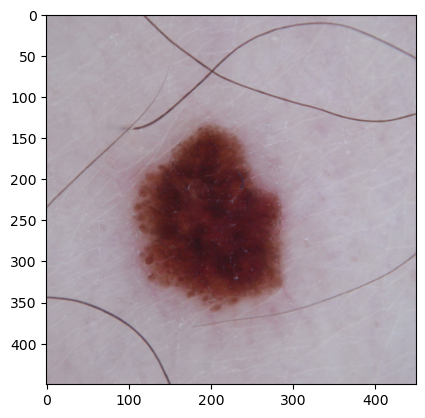

(6, 1)

In [61]:
img_name = "ISIC_0032964.jpg"
get_sample_ita_kin(TRAINING_PATH+img_name)
#ita2 = get_sample_ita_kin(TRAINING_PATH+img_name,arctan2=True)

In [ ]:
fitzpatrick = []
fitzpatrick_corrected = []
for i in range(len(df_labels)):
    img_name = df_labels["image"].iloc[i]
    ita,ita2 = get_sample_ita_kin(TRAINING_PATH+img_name)
    fitzpatrick.append(ita)
    fitzpatrick_corrected.append(ita2)
    if i % 100 ==0:
        print(i)
    if i ==10014:
        print("Finished")
df_labels["fitzpatrick_Bevan"] = fitzpatrick
df_labels["fitzpatrick_corrected"] = fitzpatrick_corrected
df_labels[["image","fitzpatrick_Bevan","fitzpatrick_corrected"]].to_csv("Bevan_corrected.csv",index=False)